In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras import layers, Model

In [2]:
def loadStackArray(path,path_20):
    print("Loading test 2017...")
    data = np.load(path)
    images, labels = data['images'], data['labels']/255.0
    del data
    print("Loading test 2020...")
    data = np.load(path_20)
    images_20, labels_20 = data['images'], data['labels']/255.0
    print("Stacking data...")
    return np.vstack([images, images_20]), np.vstack([labels, labels_20])

In [3]:
def focalLoss(alpha=0.25, gamma=3.0):
    def focal_loss(y_true, y_pred):
        y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)
        
        epsilon = K.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        focal_weight = alpha_factor * tf.pow((1 - p_t), gamma)
        bce = K.binary_crossentropy(y_true, y_pred)
        
        loss = focal_weight * bce
        return loss  # Return the loss for each image
    return focal_loss


def diceLoss(y_true, y_pred):
    y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3])
    
    smooth = 1e-6  # Adding a small constant to avoid division by zero
    dice = (2. * intersection + smooth) / (union + smooth)
    
    return 1 - dice  


def build_loss(alpha=0.25, gamma=2.0, focal_weight=0.5,dice_weight=0.5, **kwargs):
    focal_loss = focalLoss(alpha=alpha, gamma=gamma)
    
    def combined(y_true, y_pred):
        focal = focal_loss(y_true, y_pred)
        dice = diceLoss(y_true, y_pred)

        focal = tf.reduce_mean(focal, axis=0)
        dice = tf.reduce_mean(dice, axis=0)
        
        combined_loss = focal_weight * focal + dice_weight * dice
        
        return combined_loss
    
    return combined

In [4]:
gamma = 2
alpha = 0.25
custom = build_loss(alpha=alpha, gamma=gamma)
with tf.device("/CPU:0"):
    alpha_str = str(alpha).replace(".","")
    custom_objects={'combined':custom,'IoU':keras.metrics.BinaryIoU(target_class_ids=[1], name='IoU')}
    model = keras.models.load_model(f'./unet_alpha_025_gamma_2.h5', custom_objects=custom_objects)

In [5]:
orig = '../stack arrays/'
test_img, test_lbl = loadStackArray(orig+"testing_stacked_arrays_2017.npz", orig + "testing_stacked_arrays_2020.npz")

Loading test 2017...
Loading test 2020...
Stacking data...


In [6]:
test_img.shape

(22160, 256, 256, 3)

In [7]:
with tf.device("/CPU:0"):
    test_img, test_lbl = tf.convert_to_tensor(test_img), tf.convert_to_tensor(test_lbl)

In [8]:
with tf.device('/GPU:1'):
    mask = model.predict(test_img, verbose=1)

693/693 [==============================] - 216s 302ms/step


In [9]:
with tf.device('/GPU:1'):
    results = model.evaluate(test_img, test_lbl)

693/693 [==============================] - 206s 294ms/step - loss: 0.4822 - precision_2: 0.3376 - recall_2: 0.2011 - IoU: 0.1442


In [10]:
results

[0.4821830689907074,
 0.3376202881336212,
 0.2010897845029831,
 0.14419998228549957]

In [11]:
def calculateF1(precision, recall):
    return 2*precision*recall/(precision+recall)

In [12]:
calculateF1(0.3376202881336212, 0.2010897845029831)

0.25205391335024324

In [13]:
x = np.round(mask)

In [14]:
i = 0
with tf.device("/CPU:0"):
    test_labels = test_lbl.numpy()
for idx,t in enumerate(test_labels):
    if np.any(t==1) and t.sum()>1:
        i = idx
        break

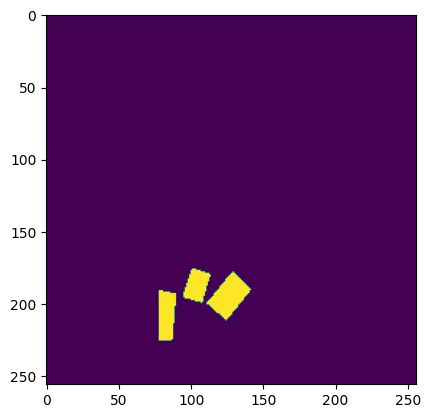

In [28]:
plt.imshow(test_labels[idx+2])

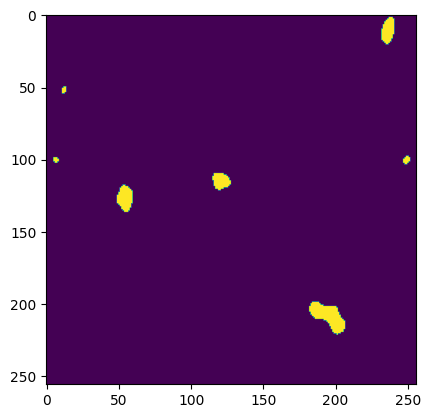

In [29]:
plt.imshow(x[idx+2])

In [17]:
with tf.device("/CPU:0"):
    test_image = test_img.numpy()

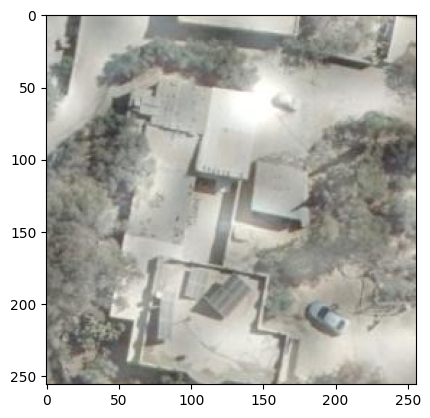

In [30]:
plt.imshow(test_image[idx+2])

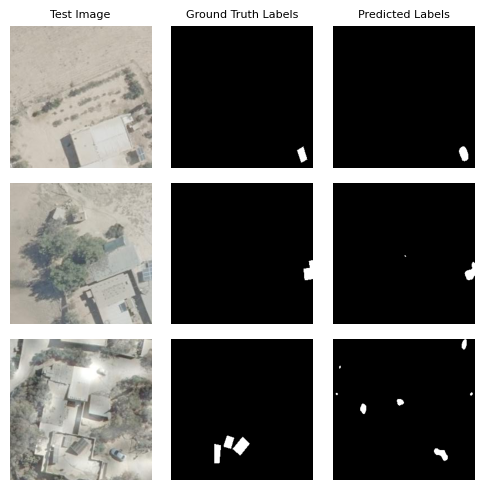

In [47]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(5, 5))

# Set column titles
ax[0, 0].set_title('Test Image', fontsize=8)
ax[0, 1].set_title('Ground Truth Labels', fontsize=8)
ax[0, 2].set_title('Predicted Labels', fontsize=8)

for i in range(3):
    # Display the test image
    ax[i, 0].imshow(test_image[idx + i])
    ax[i, 0].axis('off')
    
    # Display the ground truth labels
    ax[i, 1].imshow(test_labels[idx + i], cmap='gray')
    ax[i, 1].axis('off')
    
    # Display the predicted labels
    ax[i, 2].imshow(x[idx + i], cmap='gray')
    ax[i, 2].axis('off')

# Show the plots
plt.tight_layout()
plt.savefig('comparison_grid.png', dpi=500)
plt.show()
